In [1]:
################################
# Basic layout of the notebook #
################################
#
# 1. Load all prerequisites
# 2. Create a noise generator which outputs noise parameterized by some vars.
# 3. Create an adversary which creates adversarial images according to this noise generator.
# 4. Write a loop to display a few images (real image, regular noise, adversarial)
#
# (Unused)
# 4a. Write a loop to display a few images (real image, regular noise, adv 1, 3, 10 steps.)
# 4b. Write a function to display the averages (real image, regular noise, adv 1, 3, 10 steps.)

#########################################
# Basic layout of the problem statement #
#########################################
#
# 1. You have an image x.
# 2. You can modifiy x by adding adversarial noise to x.
# 2a. There are restrictions on the parameterization of the adversarial noise
# 2b. There are restrictions on the scale of the adversarial noise (?)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as trn

%matplotlib inline

In [2]:
test_transform = trn.Compose([trn.Resize(256), trn.CenterCrop(224), trn.ToTensor()])

mean = torch.FloatTensor(np.array([0.485, 0.456, 0.406]).reshape(1,3,1,1))#.cuda()
std = torch.FloatTensor(np.array([0.229, 0.224, 0.225]).reshape(1,3,1,1))#.cuda()

test_data = dset.ImageFolder('/Users/oliver/datasets/imagenette2/val/', transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True,
                                          num_workers=1, pin_memory=True)

In [8]:
def remove_module(state_dict):
    d = {}
    for key in state_dict:
        d[key[7:]] = state_dict[key]
    return d

net = models.resnet50()
'''
net.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/resnet50-19c8e357.pth',
                                       model_dir='/Users/oliver/models'))
'''
session = torch.load('/Users/oliver/models/deepaugment_and_augmix.pth.tar', map_location=torch.device('cpu'))
state_dict = remove_module(session['state_dict'])
net.load_state_dict(state_dict)
#'''
net.eval()
#net.cuda()
#cudnn.benchmark = True  # fire on all cylinders

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [3]:
to_np = lambda z: z.to('cpu').detach().numpy()

In [4]:
# vars are two frequencies and a phase. It's a bsize x 3
def single_frequency_creator(vars, im_size):
    '''
    Creates some noise based on some variable. 
    Creation of noise should be batched and enable gradients 
    to flow through it.
    '''
    bsize = vars[0].size(0)
    freq0, freq1, phase = vars
    x_img = torch.Tensor([[x for x in range(im_size)] for y in range(im_size)])
    y_img = torch.Tensor([[y for x in range(im_size)] for y in range(im_size)])
    pre_sine = x_img * freq0 + y_img * freq1 + phase
    noise = torch.sin(pre_sine).unsqueeze(0)
    noise = noise - noise.min() # Isn't parallelized rn. Specifically, this should take the min per image.
    return noise / noise.max() # Same here

In [5]:
class SingleFrequencyAdversary(nn.Module):
    def __init__(self, eps=0.05, scale=1, num_steps=10, step_size=0.01):
        super().__init__()
        self.eps = eps
        self.scale = scale
        self.num_steps = num_steps
        self.step_size = step_size

    def forward(self, model, bx, by, x_max):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        bsize = bx.size(0)
        
        # create initial variables
        single_frequency_vars = (
            torch.rand(bsize,),
            torch.rand(bsize,),
            torch.rand(bsize,)
        )
        print(single_frequency_vars)

        # create initial images
        adv_bx = bx.detach()
        single_frequency = single_frequency_creator(single_frequency_vars, 224) #[:,:,16:-16,16:-16]
        original_single_frequency = single_frequency.clone().detach().data

        # begin optimizing the inner loop
        # opt = optim.Adam(single_frequency_vars, lr=0.01)
        opt = optim.SGD(single_frequency_vars, lr=0.01)

        for i in range(self.num_steps):
            opt.zero_grad()

            with torch.enable_grad():
                single_frequency = single_frequency_creator(single_frequency_vars, 224) #[:,:,16:-16,16:-16]
                logits = model(((adv_bx + self.scale * single_frequency)/(x_max + self.scale) - mean)/std)
                loss = -F.cross_entropy(logits, by, reduction='sum')
                print(loss.item())
            
            loss.backward(retain_graph=True)
            opt.step()
            
            # clamp variables
            for i in range(len(single_frequency_vars)):
                single_frequency_vars[i].detach()
                # single_frequency_vars[i].data = single_frequency_vars[i].data.clamp(0, self.eps)
                single_frequency_vars[i].requires_grad_()

        print(single_frequency_vars)
        return single_frequency, original_single_frequency

In [10]:
scale = 0.1
eps = 0.05
adv = SingleFrequencyAdversary(eps, scale, num_steps=100, step_size=0.03)

In [9]:
for i, (x, label) in enumerate(test_loader):
    logits = net((x - mean)/std)
    print('Loss:', to_np(F.cross_entropy(logits, label)))
    print('Target:', label)
    if i > 5:
        break

Loss: 24.690632
Target: tensor([3])
Loss: 12.430821
Target: tensor([3])
Loss: 14.122703
Target: tensor([2])
Loss: 15.067588
Target: tensor([8])
Loss: 2.869399
Target: tensor([0])
Loss: 24.002335
Target: tensor([3])
Loss: 13.272174
Target: tensor([3])



Clean Image
Loss: 20.32925
Wrong Prediction


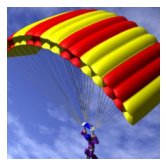


Initial Image
(tensor([0.8537]), tensor([0.7040]), tensor([0.7166]))
-20.736053466796875
-20.736053466796875
-20.482187271118164
-20.49508285522461
-20.759044647216797
-20.36820411682129
-20.704998016357422
-22.04007339477539
-21.61271858215332
-20.908109664916992
-21.346479415893555
-22.994293212890625
-21.936254501342773
-21.04140281677246
-22.005582809448242
-21.800535202026367
-21.052024841308594
-20.837818145751953
-20.193578720092773
-20.261280059814453
-20.275161743164062
-20.200986862182617
-20.786651611328125
-21.064617156982422
-21.12778663635254
-21.39992332458496
-21.364633560180664
-21.39011001586914
-21.24441146850586
-21.337675094604492
-21.411922454833984
-21.320995330810547
-21.09772491455078
-21.32528305053711
-21.315017700195312
-21.237871170043945
-21.098684310913086
-21.21677017211914
-21.34686279296875
-21.147977828979492
-21.169876098632812
-20.67141342163086
-20.591806411743164
-20.694873809814453
-20.99860191345215
-20.832056045532227
-20.92424201965332
-21.01

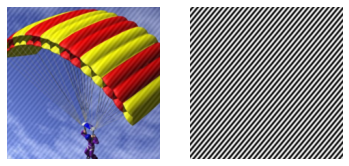


Adversarial Image
Loss: 20.91088
Wrong Prediction


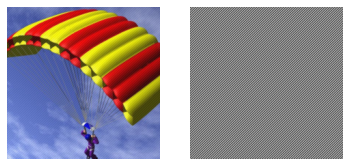


Clean Image
Loss: 19.114822
Wrong Prediction


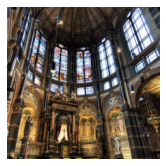


Initial Image
(tensor([0.2998]), tensor([0.8572]), tensor([0.7949]))
-19.5953369140625
-19.5953369140625
-19.381275177001953
-19.706342697143555
-18.745988845825195
-19.26552963256836
-19.423519134521484
-19.205223083496094
-19.630252838134766
-19.301881790161133
-19.386953353881836
-19.373109817504883
-19.547515869140625
-19.467330932617188
-19.398719787597656
-19.40317153930664
-19.459850311279297
-19.36769676208496
-19.47368812561035
-19.490877151489258
-19.37824249267578
-19.510160446166992
-19.462215423583984
-19.523136138916016
-19.417673110961914
-19.412954330444336
-19.458881378173828
-19.446823120117188
-19.384796142578125
-19.346519470214844
-19.447690963745117
-19.31237030029297
-19.499652862548828
-19.455354690551758
-19.57375717163086
-19.51249885559082
-19.47775650024414
-19.441476821899414
-19.4746036529541
-19.45395851135254
-19.3681583404541
-19.49712371826172
-19.55349349975586
-19.43915557861328
-19.37321662902832
-19.582576751708984
-19.445301055908203
-19.57325553

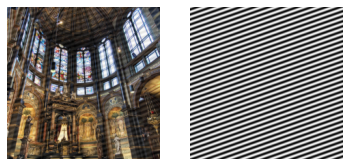


Adversarial Image
Loss: 19.484653
Wrong Prediction


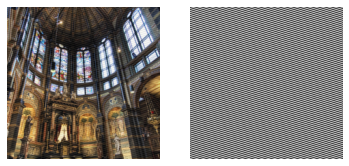


Clean Image
Loss: 12.668537
Wrong Prediction


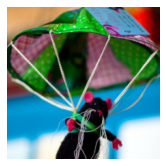


Initial Image
(tensor([0.6058]), tensor([0.8978]), tensor([0.3019]))
-14.004314422607422
-14.004314422607422
-13.249686241149902
-14.062411308288574
-13.164029121398926
-13.369195938110352
-13.59657096862793
-13.563283920288086
-13.557418823242188
-15.146085739135742
-13.703217506408691
-12.97122859954834
-12.822774887084961


In [ ]:
for i, (x, label) in enumerate(test_loader):
    if i < 3:
    
        print('\nClean Image')
        target = torch.LongTensor([label])#.cuda()

        x = x#.cuda()
        x_max, _ = torch.max(x.view(x.size(0), 3, -1), -1)
        x_max = x_max.view(-1, 3, 1, 1)

        logits = net((x - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1) # induced for comparable size
        plt.imshow(to_np(x).squeeze().transpose((1,2,0)))
        plt.axis('off')
        plt.show()

        print('\nInitial Image')

        adv_template, original_template = adv(net, x, target, x_max)
        
        logits = net(((x + scale * original_template)/(x_max + scale) - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])
        
        plt.subplot(1,2,1)
        plt.imshow(to_np((x + scale * original_template)/(x_max + scale)).squeeze().transpose((1,2,0)))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.imshow(to_np(original_template).squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()
        
        print('\nAdversarial Image')
        
        logits = net(((x + scale * adv_template)/(x_max + scale) - mean)/std)
        print('Loss:', to_np(F.cross_entropy(logits, target)))
        print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])

        plt.subplot(1,2,1)
        plt.imshow(to_np((x + scale * adv_template)/(x_max + scale)).squeeze().transpose((1,2,0)))
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(to_np(adv_template).squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()
        
    else:
        break


Clean Image
Loss: 10.026253
Wrong Prediction


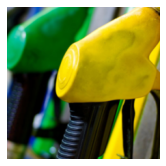


Initial Image
(tensor([0.6744]), tensor([0.8360]), tensor([0.6714]))


In [11]:
for i, (x, label) in enumerate(test_loader):
    print('\nClean Image')
    target = torch.LongTensor([label])#.cuda()

    x = x#.cuda()
    x_max, _ = torch.max(x.view(x.size(0), 3, -1), -1)
    x_max = x_max.view(-1, 3, 1, 1)

    logits = net((x - mean)/std)
    print('Loss:', to_np(F.cross_entropy(logits, target)))
    print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])

    plt.subplot(1,2,1) # induced for comparable size
    plt.imshow(to_np(x).squeeze().transpose((1,2,0)))
    plt.axis('off')
    plt.show()

    print('\nInitial Image')

    adv_template, original_template = adv(net, x, target, x_max)

    logits = net(((x + scale * original_template)/(x_max + scale) - mean)/std)
    print('Loss:', to_np(F.cross_entropy(logits, target)))
    print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])

    plt.subplot(1,2,1)
    plt.imshow(to_np((x + scale * original_template)/(x_max + scale)).squeeze().transpose((1,2,0)))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(to_np(original_template).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()

    print('\nAdversarial Image')

    logits = net(((x + scale * adv_template)/(x_max + scale) - mean)/std)
    print('Loss:', to_np(F.cross_entropy(logits, target)))
    print(['Wrong Prediction', 'Right Prediction'][int(label == to_np(torch.argmax(logits, 1))[0])])

    plt.subplot(1,2,1)
    plt.imshow(to_np((x + scale * adv_template)/(x_max + scale)).squeeze().transpose((1,2,0)))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(to_np(adv_template).squeeze(), cmap='gray')
    plt.axis('off')
    plt.show()